<a href="https://colab.research.google.com/github/SDashev/Springboard-Capstone-2/blob/master/Capstone_2_ml_model_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook uses Google colab to run

We will run model with transfer learning using exactly the same data used to train model from scratch. We will not shuffle or make any alterations to data we did not do using the model from scratch. 

This way, we will be able to truly compare the two types of models.

In [0]:
!pip install PyDrive

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 30 21:07:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Fetching data

In [0]:
# in the colab files, I created work directory and moved the working directory.
os.chdir( 'work')

In [0]:
download = drive.CreateFile({'id': '1-0DzB-dUXarKs6GtULkZceszlyx9BcfT'})
download.GetContentFile('fruit-recognition.zip')

In [0]:
download = drive.CreateFile({'id': '1jQ7nVkoI8xGFKJNTmhBHwU6iS4_EPmd5'})
download.GetContentFile('files_for_ml_cs2.zip')

In [0]:
!unzip -q fruit-recognition.zip  
!ls

Apple	   files_for_ml_cs2.zip   Kiwi	     Orange  Persimmon	Pomegranate
Banana	   fruit-recognition.zip  Mango      Peach   Pitaya	Tomatoes
Carambola  Guava		  muskmelon  Pear    Plum


In [0]:
!unzip -q files_for_ml_cs2.zip  
!ls

Apple			label_classes.csv  Pomegranate
Banana			Mango		   Tomatoes
Carambola		muskmelon	   X_train_filenames.npy
file_names_data.npy	Orange		   X_val_filenames.npy
filenames_shuffled.npy	Peach		   y_label_one_hot.npy
files_for_ml_cs2.zip	Pear		   y_labels_one_hot_shuffled.npy
fruit-recognition.zip	Persimmon	   y_train.npy
Guava			Pitaya		   y_val.npy
Kiwi			Plum


In [0]:
!rm fruit-recognition.zip
!rm files_for_ml_cs2.zip
%reset_selective download

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Build model

In [0]:
import numpy as np
import pandas as pd

import tensorflow.keras

from tensorflow.keras import applications

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

from cv2 import imread
import matplotlib.pyplot as plt



In [0]:
#Build CNN with transfer learning from VGG16 trained on imagenet
#from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16

cbase=applications.VGG16(weights='imagenet', include_top=False, input_shape=(258, 320, 3)) 
cbase.trainable=False # freeze convolutional base

transfer_m = Sequential()
transfer_m.add(cbase)

transfer_m.add(Flatten())

transfer_m.add(Dense(128, activation='relu', use_bias=
                     True, bias_initializer='zeros' ))
transfer_m.add(Dropout(0.25))

transfer_m.add(Dense(15, activation='softmax'))

transfer_m.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 10, 512)        14714688  
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5243008   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 19,959,631
Trainable params: 5,244,943
Non-trainable params: 14,714,688
_________________________________________________________________


## Custom data generator

In [0]:
class My_Custom_Generator(tensorflow.keras.utils.Sequence):

  from cv2 import imread

  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames = image_filenames

    self.labels = labels

    self.batch_size = batch_size

    
  def __len__(self) :

    return (np.ceil(len(self.image_filenames) / float(
        self.batch_size))).astype(np.int)

  

  def __getitem__(self, idx) :

    batch_x = self.image_filenames[idx * self.batch_size : (
        idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            (imread(str(file_name))) for file_name in batch_x])/255.0, np.array(
                batch_y)

In [0]:
# loading variables
#from keras.utils import to_categorical

# loading variables
X_train = np.load('X_train_filenames.npy')
y_train = (np.load('y_train.npy'))

X_df = list(X_train)
y_df = list(y_train)

X_train_files = np.array(X_df[:44263])
y_train_values = np.array(y_df[:44263])
X_val_files = np.array(X_df[44263:])
y_val_values = np.array(y_df[44263:])

X_test_files = np.load('X_val_filenames.npy')
y_test = (np.load('y_val.npy'))
name_classes = pd.read_csv('label_classes.csv')

In [0]:
batch_size = 95

my_training_batch_generator = My_Custom_Generator(
    X_train_files, y_train_values, batch_size)
my_validation_batch_generator = My_Custom_Generator(
    X_val_files, y_val_values, batch_size)

## Running model

In [0]:
transfer_m.compile(loss='categorical_crossentropy',optimizer=
                   'adam',metrics=['accuracy'])

load_weights = False #load weights if not re-fitting
if load_weights:
    transfer_m.load_weights('../model/vgg_baseline.hdf5')

In [0]:
#from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=2)
if load_weights!=True:
  record = transfer_m.fit(x=my_training_batch_generator,
                 steps_per_epoch = int(44263 // batch_size),
                   epochs = 30,
                   #verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(4917 // batch_size),
                   shuffle=False,
                   callbacks=[early_stop_mon])

Epoch 1/30
465/465 [==============================] - 232s 499ms/step - loss: 0.7997 - accuracy: 0.7600 - val_loss: 0.1463 - val_accuracy: 0.9680
Epoch 2/30
465/465 [==============================] - 211s 454ms/step - loss: 0.3107 - accuracy: 0.8883 - val_loss: 0.0695 - val_accuracy: 0.9835
Epoch 3/30
465/465 [==============================] - 207s 445ms/step - loss: 0.2394 - accuracy: 0.9103 - val_loss: 0.0615 - val_accuracy: 0.9810
Epoch 4/30
465/465 [==============================] - 206s 443ms/step - loss: 0.2184 - accuracy: 0.9160 - val_loss: 0.0445 - val_accuracy: 0.9886
Epoch 5/30
465/465 [==============================] - 206s 443ms/step - loss: 0.1929 - accuracy: 0.9260 - val_loss: 0.0470 - val_accuracy: 0.9878
Epoch 6/30
465/465 [==============================] - 204s 439ms/step - loss: 0.1836 - accuracy: 0.9291 - val_loss: 0.0477 - val_accuracy: 0.9841


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path_model = '../gdrive/My Drive/Capstone 2/cs2-repo/Springboard-Capstone-2/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
save_weights = True
if save_weights:
    transfer_m.save('../gdrive/My Drive/Capstone 2/cs2-repo/Springboard-Capstone-2/models/baseline_transfer.hdf5')
    #save history too
    hist_df=pd.DataFrame.from_dict(record.history)
    hist_df.to_csv('../gdrive/My Drive/Capstone 2/cs2-repo/Springboard-Capstone-2/models/history_transfer.csv')

In [0]:
#transfer_m.load_weights('../model/baseline_transfer.hdf5')

In [0]:
#hist=pd.read_csv('../model/history_transfer.csv')

## Evaluate model

In [0]:
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.799727,0.760000,0.146256,0.968008
1,0.310730,0.888331,0.069453,0.983488
2,0.239365,0.910334,0.061470,0.981011
3,0.218425,0.916016,0.044483,0.988648
4,0.192901,0.925976,0.046989,0.987822


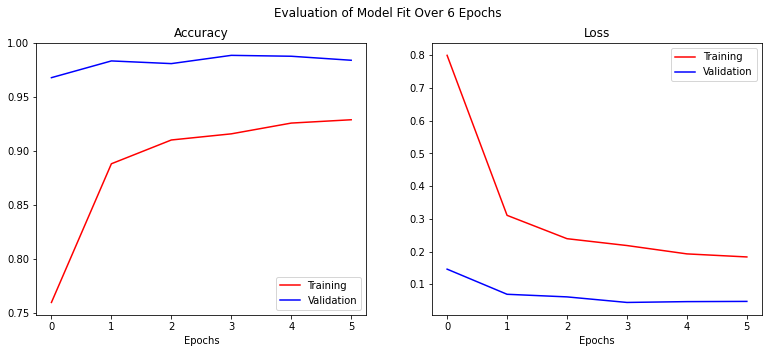

In [0]:
# Plot model fitting
# adapted from Deep Learning With Python (Chollet)
h = transfer_m.history
epochs = hist_df.index
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, hist_df['accuracy'], 'r', label='Training')
ax[0].plot(epochs, hist_df['val_accuracy'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, hist_df['loss'], 'r', label='Training')
ax[1].plot(epochs, hist_df['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over {} Epochs'.format(hist_df.shape[0]));

## Build model with different base

In [0]:
#Build CNN with transfer learning from VGG16 trained on imagenet
#from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16

cbase=applications.VGG19(weights='imagenet', include_top=False, input_shape=(258, 320, 3)) 
cbase.trainable=False # freeze convolutional base

transfer_m = Sequential()
transfer_m.add(cbase)

transfer_m.add(Flatten())

transfer_m.add(Dense(128, activation='relu', use_bias=
                     True, bias_initializer='zeros' ))
transfer_m.add(Dropout(0.25))

transfer_m.add(Dense(15, activation='softmax'))

transfer_m.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 10, 512)        20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               5243008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1935      
Total params: 25,269,327
Trainable params: 5,244,943
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
transfer_m.compile(loss='categorical_crossentropy',optimizer=
                   'adam',metrics=['accuracy'])

transfer_m.fit(x=my_training_batch_generator,
                 steps_per_epoch = int(44263 // batch_size),
                   epochs = 2,
                   #verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(4917 // batch_size),
                   shuffle=False,
                   callbacks=[early_stop_mon])

Epoch 1/2
465/465 [==============================] - 224s 481ms/step - loss: 0.9999 - accuracy: 0.7040 - val_loss: 0.2436 - val_accuracy: 0.9422
Epoch 2/2
465/465 [==============================] - 223s 479ms/step - loss: 0.4070 - accuracy: 0.8584 - val_loss: 0.1215 - val_accuracy: 0.9664
